In [2]:
from huggingface_hub import InferenceClient
import os
import json

import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

import boto3

from openai import OpenAI

oa_client = OpenAI()


In [27]:
api_key = os.getenv("HUGGING_FACE_HUB_TOKEN")
hf_client = InferenceClient(api_key=api_key )

# Optionally specify the profile you want to use
session = boto3.Session(profile_name="sandbox_administrator")  # Replace with your profile name
s3_client = session.client("s3")

local_image_folder = "demo_images"
MY_MODEL = 'gpt-4o'

In [28]:
def upload_image_to_s3(file_path, bucket_name, object_key):
    """
    Uploads an image to the specified S3 bucket and generates a presigned URL.
    
    Parameters:
        file_path (str): Local path to the image file.
        bucket_name (str): Name of the S3 bucket.
        object_key (str): Key (path) where the image will be stored in the S3 bucket.
        
    Returns:
        str: Presigned URL for the uploaded image, valid for a limited time.
    """
    # Upload the file to S3
    try:
        s3_client.upload_file(file_path, bucket_name, object_key)
        # print(f"Image successfully uploaded to s3://{bucket_name}/{object_key}")
    except Exception as e:
        print(f"Error uploading image: {e}")
        return None
    
    # Generate a presigned URL for the uploaded file with a limited duration
    try:
        presigned_url = s3_client.generate_presigned_url(
            'get_object',
            Params={'Bucket': bucket_name, 'Key': object_key},
            ExpiresIn=3600  # URL valid for 1 hour
        )
        return presigned_url
    except Exception as e:
        print(f"Error generating presigned URL: {e}")
        return None



In [29]:
def display_image(image_url):
    #response = requests.get(image_url)
    #img = Image.open(BytesIO(response.content))

    img = Image.open(image_url)
    
    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis("off")  # Hide the axis
    plt.show()

In [30]:
def prep_and_upload_image(image_file_name):
    # Parameters for S3 upload
    local_image_path = local_image_folder+"/"+image_file_name  # Replace with your local image path
    bucket_name = "realmir2"            # Replace with your S3 bucket name
    object_key = image_file_name      # Replace with your desired S3 path and file name


    # display image
    display_image(local_image_path)

    
    # Upload image and get presigned URL
    uploaded_image_url = upload_image_to_s3(local_image_path, bucket_name, object_key)
    if uploaded_image_url is None:
        raise Exception("Failed to upload image and generate presigned URL.")

    return uploaded_image_url

In [31]:

def describe(query, image_file, stream=True):
    try:

        image_url = prep_and_upload_image(image_file)

        if stream:

            for message in hf_client.chat_completion(
                model="meta-llama/Llama-3.2-11B-Vision-Instruct",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "image_url", "image_url": {"url": image_url}},
                            {"type": "text", "text": query+" Don't use the word image or picture"},
                        ],
                    }
                ],
                max_tokens=500,
                stream=True,
            ):
                # Check if message has the expected structure and handle exceptions
                if "choices" in message and message.choices[0].delta:
                    print(message.choices[0].delta.content, end="")

        else:
            response = hf_client.chat_completion(
                model="meta-llama/Llama-3.2-11B-Vision-Instruct",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "image_url", "image_url": {"url": image_url}},
                            {"type": "text", "text": query+" Don't use the word image or picture"},
                        ],
                    }
                ],
                max_tokens=500,
                stream=False,
            )
            return response
                
    except json.JSONDecodeError as e:
        print("An error occurred while decoding JSON:", e)
    except Exception as e:
        print("An unexpected error occurred:", e)



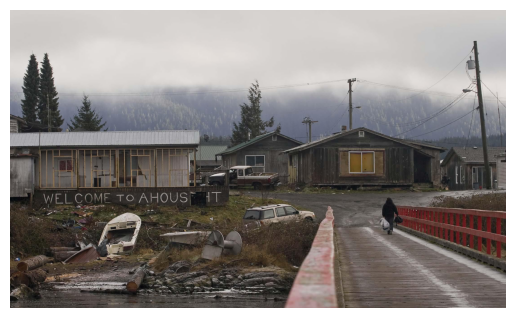

The scene shows a small town or village, likely set in a coastal or mountainous area. The town is surrounded by dense forest, and the atmosphere is peaceful and serene. The camera captures a gentle waterscape, with a calm sea or lake in the backdrop.

To the left, a narrow road winds its way along the coast, lined with small, rustic cottages and buildings. The roofs are covered in moss and lichen, giving the impression of age and worn-down stone.

A small, wooden church stands at the center of the scene, its steeply sloping roof and tall spire reaching towards the sky. Alongside the church, a group of villagers is gathered, their faces weathered and worn from years of living in the harsh environment.

The ground is covered with a thick layer of moss and undergrowth, and the trees surrounding the town are still in their autumnal orange and red hues. A severe storm seems to have recently passed through the area, leaving behind debris and wreckage.

Further to the right, the sea laps gent

In [144]:
describe("Tell me what you see","reservation.jpg", True)

In [1]:
describe("Do you see a green car","traffic_1.jpg", True)

NameError: name 'describe' is not defined

## Watching 

In [135]:

def find_object(thing,image):

    hf_response = describe("Do you see "+thing,image, False)
    image_content = hf_response.choices[0].message.content
    
    tools = [
        {
            "type": "function",
            "function": {
                "name": "found_it",
                "description": "Describe the "+thing+". Call this whenever you are told that there is a "+thing,
                "parameters": {
                    "type": "object",
                    "properties": {
                        "the_description": {
                            "type": "string",
                            "description": "A description of the "+thing
                        }
                    },
                    "required": ["bicycle_description"],
                    "additionalProperties": False
                }
            }
        }
    ]
    
    messages = []
    messages.append({"role": "system", "content": "You are a helpful assistant viewing a video stream and looking at the images you see. "})
    messages.append({"role": "user", "content": "Tell me if you see "+thing})
    messages.append({"role": "user", "content": image_content})
    
    
    
    results = oa_client.chat.completions.create(
        model=MY_MODEL,
        messages=messages,
        tools=tools
    )
    
    if results.choices[0].message.tool_calls:
        print(results.choices[0].message.tool_calls[0].function)
    else:
        # print(results.choices[0].message.content)
        print(thing+" not found")

    # return results


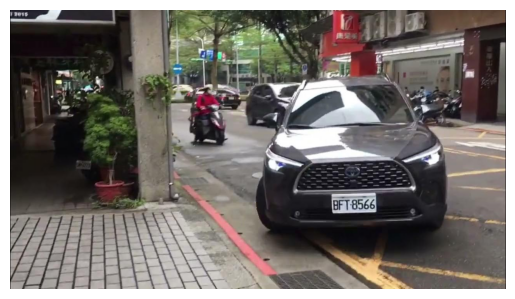

Function(arguments='{"the_description":"A black car with a license plate starting with \'BFT\' is driving on a road in an urban area. The background includes buildings and trees, along with other vehicles such as cars, motorcycles, and a scooter."}', name='found_it')


In [147]:
results = find_object("A car with license plate starting with BFT","parking_lot_1.jpg")